In [1]:
import pandas as pd

data = pd.read_csv('anderson93.csv', infer_datetime_format=True, parse_dates=['Dates'], names=['Artist','Album','Song','Dates'], encoding = 'utf_8')
data[:5]

,Artist,Album,Song,Dates
0,Tame Impala,Lonerism,Elephant,2018-01-12 23:35:00
1,Peter Bjorn and John,Writer's Block,Young Folks,2018-01-12 23:30:00
2,Interpol,Antics,Evil,2018-01-12 23:27:00
3,MGMT,Congratulations,Flash Delirium,2018-01-12 23:22:00
4,Bloc Party,Silent Alarm (U.S. Version),Banquet,2018-01-12 22:08:00


In [2]:
import datetime
import sqlite3
from pandas.io import sql

# sqlite_file = 'last_fm_db.sqlite'    # name of the sqlite database file

# Connecting to the database file
conn = sqlite3.connect(':memory:')
c = conn.cursor()
conn.text_factory = str

# sql.write_frame(data, name='anderson93', con=conn)
data.to_sql("anderson93",conn)

# # Committing changes and closing the connection to the database file
conn.commit()
# conn.close()

In [3]:
# c.execute("SELECT name FROM sqlite_master WHERE type='table';")
# c.fetchall()

In [4]:
years = {}
for year in xrange(2010,2018):
    sql_query = """
    SELECT distinct Artist AS Artists, COUNT(Artist) AS CountOf{0} \
    FROM anderson93 \
    WHERE Dates BETWEEN '{0}-01-01' AND '{0}-12-31' \
    GROUP BY Artists \
    ORDER BY CountOf{0} DESC \
    """.format(year)
    temp_df = pd.read_sql_query(sql_query , conn)
    if not temp_df.empty:
        years[year] = temp_df


In [5]:
# keys = sorted(years.keys())

# for year in keys:
#     if year == keys[0]:
#         yearly_freq = pd.merge(years[year], years[year+1], on='Artists', how='outer')
#     elif year == keys[1]:
#         pass
#     else:
#         yearly_freq = pd.merge(yearly_freq, years[year], on='Artists', how='outer')
# yearly_freq = yearly_freq.fillna(0)
# yearly_freq[:5]

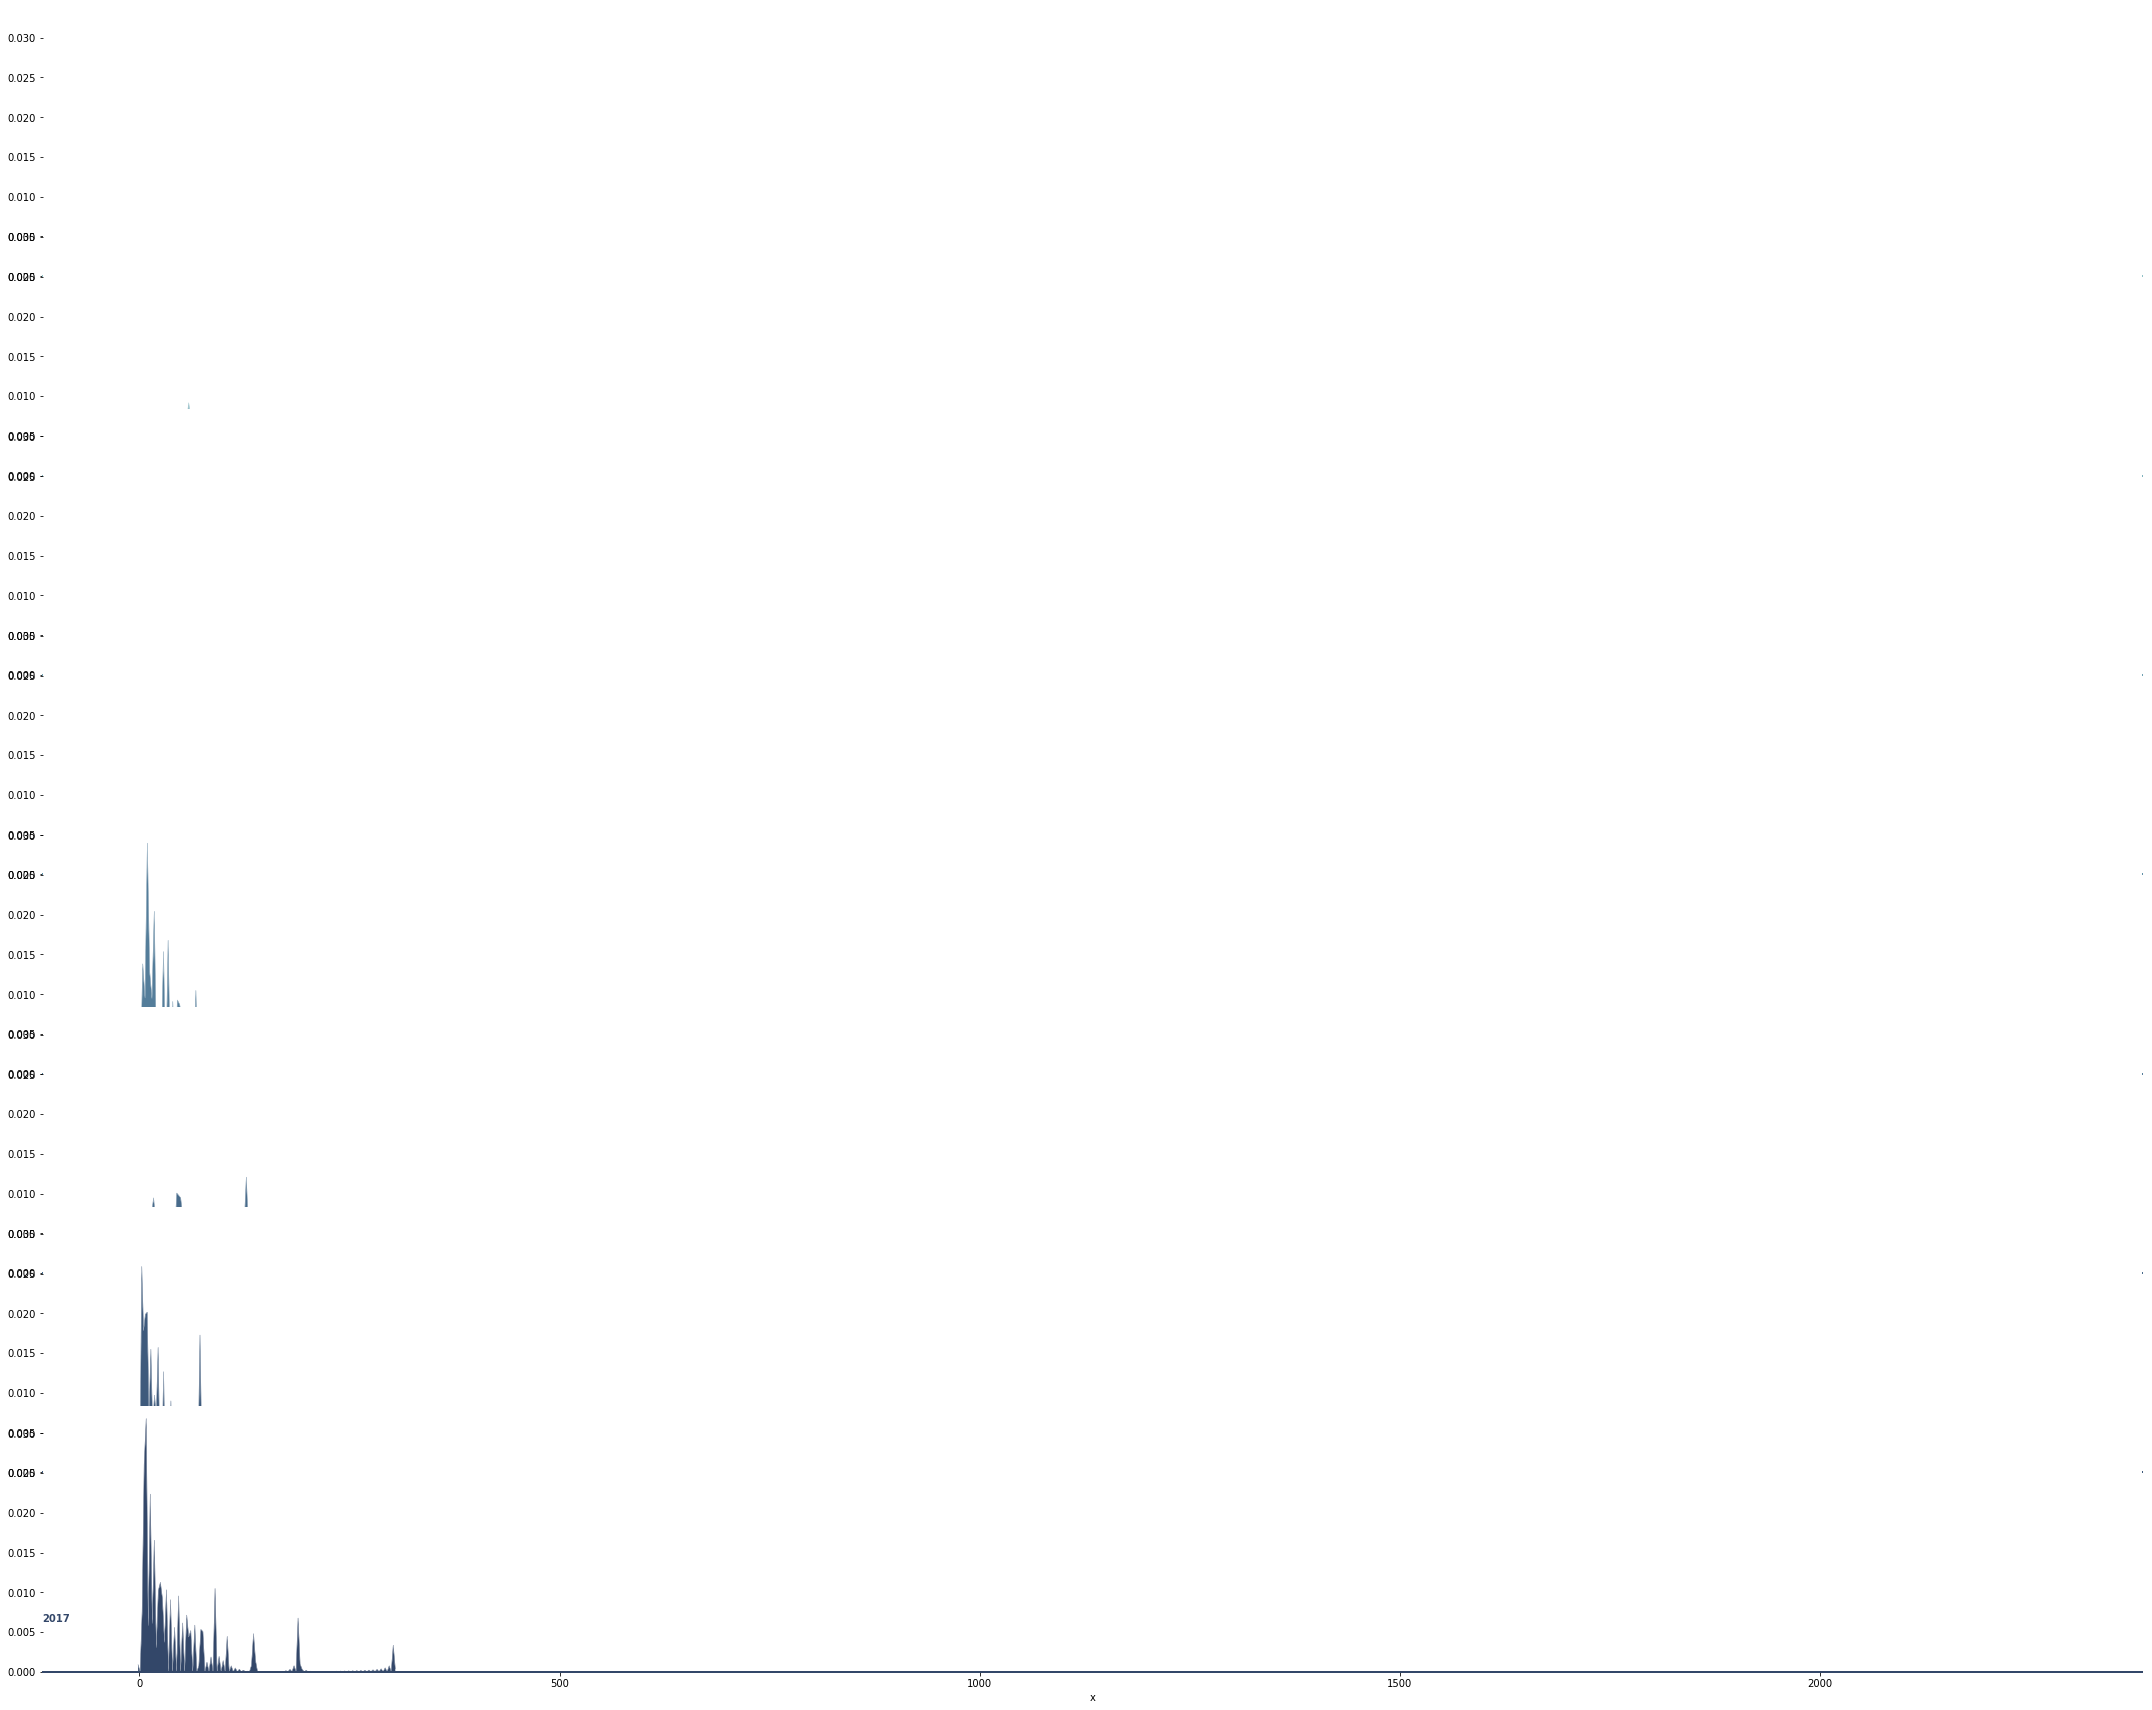

In [10]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# sns.set(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})

keys = sorted(years.keys())

for year in keys:
    if year == keys[0]:
        yearly_freq = pd.merge(years[year], years[year+1], on='Artists', how='outer')
    elif year == keys[1]:
        pass
    else:
        yearly_freq = pd.merge(yearly_freq, years[year], on='Artists', how='outer')

yearly_freq = yearly_freq.fillna(0)

aux_3 = yearly_freq
x = 0
aux_4 = []
for x in xrange(0,len(aux_3)):
    mean = aux_3['CountOf2011'][x] + aux_3['CountOf2012'][x] + aux_3['CountOf2013'][x] + aux_3['CountOf2014'][x] + aux_3['CountOf2015'][x] + aux_3['CountOf2016'][x] + aux_3['CountOf2017'][x]
    mean /= 6
    if mean <= 30:
        aux_4.append(x)
    else:
        pass

for row in sorted(aux_4,reverse=True):
    aux_3 = aux_3.drop(aux_3.index[row])

artists = list(aux_3['Artists'].map(str))

aux = aux_3

del aux['Artists']
aux = aux.reset_index(drop=True)
g = []
x = []
for row in xrange(0,len(aux)):
    for key in aux.keys():
        g.append(key.strip('CountOf'))
        x.append(aux[key][row])

df = pd.DataFrame(dict(x=x, g=g))

# Initialize the FacetGrid object
pal = sns.cubehelix_palette(10, rot=-.25, light=.7)
g = sns.FacetGrid(df, row="g", hue="g", aspect=10, size=3, palette=pal)

# Draw the densities in a few steps
g.map(sns.kdeplot, "x", clip_on=True, shade=True, alpha=1, lw=.5, bw=.5)
g.map(sns.kdeplot, "x", clip_on=True, color="w", lw=.2, bw=.5)
g.map(plt.axhline, y=0, lw=2, clip_on=False)

# Define and use a simple function to label the plot in axes coordinates
def label(x, color, label):
    ax = plt.gca()
    ax.text(0, .2, label, fontweight="bold", color=color, 
            ha="left", va="center", transform=ax.transAxes)

g.map(label, "x")

# Set the subplots to overlap
g.fig.subplots_adjust(hspace=-.25)

# Remove axes details that don't play will with overlap
g.set_titles("")

aux_0 = [a for a in artists]

# plt.xscale('log')

plt.figure(figsize=(4, 4))

# g.set_xticklabels(rotation=90)

g.despine(bottom=True, left=True)

# plt.setp(aux_0, rotation=90, horizontalalignment='right')

plt.show()

#     plt.savefig'foo%s.png'%(i))

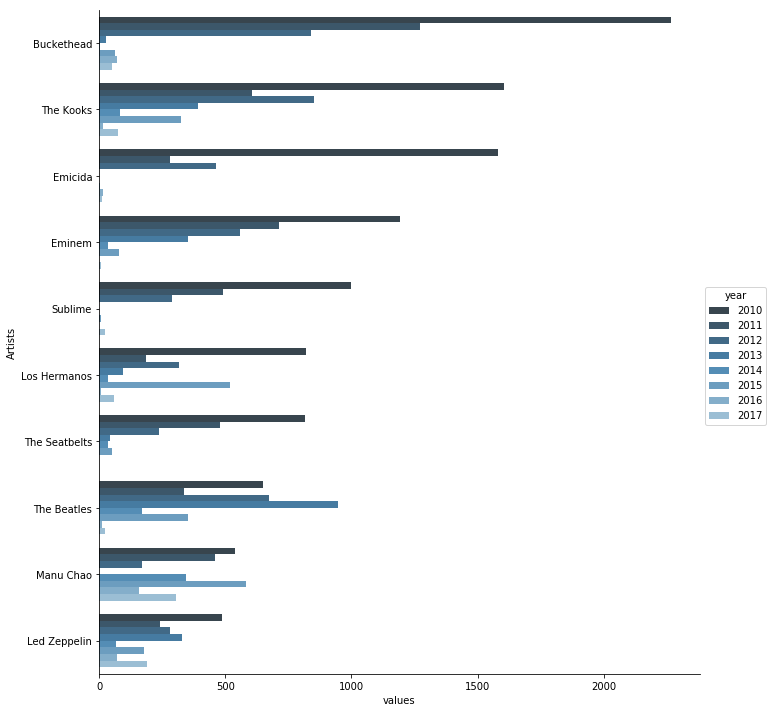

In [15]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sys 
reload(sys) 
sys.setdefaultencoding("utf-8")
import csv
import unicodedata

def remove_accents(input_str):
    nkfd_form = unicodedata.normalize('NFKD', unicode(input_str))
    return str(u"".join([c for c in nkfd_form if not unicodedata.combining(c)]))

keys = sorted(years.keys())

for year in keys:
    if year == keys[0]:
        yearly_freq = pd.merge(years[year], years[year+1], on='Artists', how='outer')
    elif year == keys[1]:
        pass
    else:
        yearly_freq = pd.merge(yearly_freq, years[year], on='Artists', how='outer')

yearly_freq = yearly_freq.fillna(0)

def fm_append(a,b):
    for x in xrange(0,len(b)):
        a.append(b[x][0])
    return list(set(a))

arti = list(yearly_freq['Artists'])
dict_fm = {x:[] for x in list(yearly_freq.keys()[1:])}
winners = []

for col in list(yearly_freq.keys()[1:]):
    plays = list(yearly_freq[col])
    dict_fm[col] = sorted([(arti[x],plays[x]) for x in xrange(0,len(yearly_freq))],key=lambda x: x[1], reverse=True)
    winners = fm_append(winners, dict_fm[col][:5])

aux_3 = yearly_freq[yearly_freq['Artists'].isin(winners)].reset_index(drop=True)
tidy_df = pd.melt(aux_3, 
            id_vars='Artists', 
            value_vars=['CountOf2010', 'CountOf2011', 'CountOf2012', 'CountOf2013', 'CountOf2014', 'CountOf2015', 'CountOf2016', 'CountOf2017'],
            var_name='year', 
            value_name='values')
tidy_df['year'] = map(lambda x: x.strip('CountOf'), tidy_df['year'])
tidy_df['values'] = map(int,tidy_df['values'])

# g = sns.FacetGrid(tidy_df, row="year", size=3, aspect=4)

# g.map(plt.hist, "values",label=tidy_df['Artists'], clip_on=True, histtype='barstacked', rwidth=0.9)

sns.factorplot( x="values", y="Artists", hue="year", data=tidy_df, order=tidy_df['Artists'][:10], palette="Blues_d", kind='bar', size=10, orient='h')

# g.set(xticklabels=tidy_df['Artists'])

# g.set_axis_labels("")
# g.set_xticklabels(tidy_df['Artists'])
# g.despine(left=True)

# g.set_major_locator(MaxNLocator(integer=True))

# g.set_xticklabels()

# plt.axis(xmax=.5)  

plt.show()

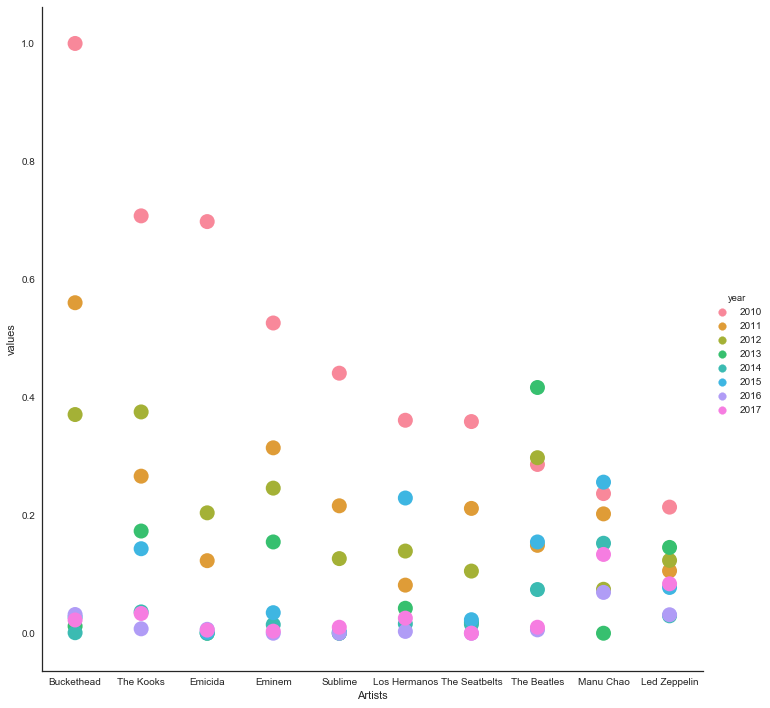

In [497]:
def normalizeDF(df):
    lmax = max([x for x in list(df.max()) if type(x)!=str])
    lmin = min([x for x in list(df.min()) if type(x)!=str])
    for key in df.keys()[1:]:
        df[key] = df[key].apply(lambda x: type(x)==str and x or (x-lmin)/(lmax-lmin))
    return df
    
yearly_freq = normalizeDF(yearly_freq)

arti = list(yearly_freq['Artists'])
dict_fm = {x:[] for x in list(yearly_freq.keys()[1:])}
winners = []

for col in list(yearly_freq.keys()[1:]):
    plays = list(yearly_freq[col])
    dict_fm[col] = sorted([(arti[x],plays[x]) for x in xrange(0,len(yearly_freq))],key=lambda x: x[1], reverse=True)
    winners = fm_append(winners, dict_fm[col][:5])

aux_3 = yearly_freq[yearly_freq['Artists'].isin(winners)].reset_index(drop=True)

tidy_df = pd.melt(aux_3, 
            id_vars='Artists', 
            value_vars=['CountOf2010', 'CountOf2011', 'CountOf2012', 'CountOf2013', 'CountOf2014', 'CountOf2015', 'CountOf2016', 'CountOf2017'],
            var_name='year', 
            value_name='values')

tidy_df['year'] = map(lambda x: x.strip('CountOf'), tidy_df['year'])
tidy_df['values'] = map(float,tidy_df['values'])

sns.factorplot( x="Artists", y="values", hue="year", data=tidy_df, order=tidy_df['Artists'][:10], size=10, kind="strip", s=15)

# plt.ylim(0,1)
# plt.yscale('log')

plt.show()

In [486]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})

# Create the data
rs = np.random.RandomState(1979)
x = rs.randn(500)
g = np.tile(list("ABCDEFGHIJ"), 50)
df = pd.DataFrame(dict(x=tidy_df['Artists'], g=tidy_df['year']))
# m = df.g.map(ord)
# df["x"] += m

# Initialize the FacetGrid object
pal = sns.cubehelix_palette(10, rot=-.25, light=.7)
g = sns.FacetGrid(df, row="g", hue="g", aspect=15, size=.5, palette=pal)

# Draw the densities in a few steps
g.map(sns.kdeplot, "x", clip_on=False, shade=True, alpha=1, lw=1.5, bw=.2)
g.map(sns.kdeplot, "x", clip_on=False, color="w", lw=2, bw=.2)
g.map(plt.axhline, y=0, lw=2, clip_on=False)

# Define and use a simple function to label the plot in axes coordinates
def label(x, color, label):
    ax = plt.gca()
    ax.text(0, .2, label, fontweight="bold", color=color, 
            ha="left", va="center", transform=ax.transAxes)

g.map(label, "x")

# Set the subplots to overlap
g.fig.subplots_adjust(hspace=-.25)

# Remove axes details that don't play will with overlap
g.set_titles("")
g.set(yticks=[])
g.despine(bottom=True, left=True)
plt.show()

ValueError: could not convert string to float: Tame Impala

0.0